#  Logistic Regression and Classification Error Metrics

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

In [1]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['data']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [2]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [3]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [4]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [5]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [6]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [7]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

3671    1
8939    0
5533    1
6623    5
996     2
Name: Activity, dtype: int32

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [9]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

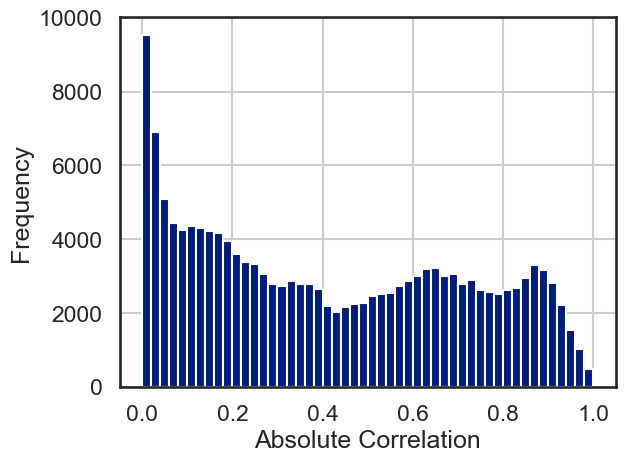

In [11]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [12]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']


In [14]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [16]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(max_iter=500, penalty='none').fit(X_train, y_train)
lr.coef_

C:\Users\anamb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


array([[-6.89218914e+01,  1.31694549e+01,  1.48262119e+01, ...,
         6.17647645e+02, -2.42844838e+02, -4.99637832e+01],
       [-2.33266480e+02, -9.16757759e+01,  2.47559619e+01, ...,
        -6.35108850e+01, -1.30038010e+02, -9.12490624e+01],
       [ 1.05008374e+02,  7.11854036e+01,  7.84911166e+01, ...,
        -2.64596519e+02,  2.20295963e+02,  1.91398070e+01],
       [ 2.02563067e-01, -1.77796524e+01,  4.22346616e+00, ...,
        -1.12917536e+02,  6.49807368e+00,  6.08757655e+01],
       [ 1.38795496e+02,  3.17815618e+01,  1.59771400e+00, ...,
        -2.29701612e+02, -1.63744008e+01, -7.69389385e+00],
       [ 5.81819383e+01, -6.68099199e+00, -1.23894471e+02, ...,
         5.30789074e+01,  1.62463212e+02,  6.88911669e+01]])

In [17]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [18]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations
saga = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga').fit(X_train, y_train)

C:\Users\anamb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\anamb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\anamb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\anamb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:350: Conve

 A penalidade l1 é aplicável para os algorítmos de resolução 'liblinear' e 'saga'

In [20]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train, y_train)

In [21]:
lbfgs = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='lbfgs', max_iter=100).fit(X_train, y_train)
liblinear_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear', max_iter=100).fit(X_train, y_train)
newton1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cg', max_iter=100).fit(X_train, y_train)
newton2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cholesky', max_iter=100).fit(X_train, y_train)
sag = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='sag', max_iter=100).fit(X_train, y_train)
saga_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='saga', max_iter=100).fit(X_train, y_train)

C:\Users\anamb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\anamb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

KeyboardInterrupt: 

A penalidade l2 é aplicável para os algorítmos de resolução 'lbfgs', 'liblinear', 'newton', 'sag' e 'saga'

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [22]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

#for lab,mod in zip(coeff_labels, coeff_models):
#    coeffs = mod.coef_
#    levels=[[lab], [0,1,2,3,4,5]]
#    labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]]
#    coeff_label = pd.MultiIndex(levels,labels)
#    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)



lr                                                               \
              0           1            2           3           4           5   
513   15.869922  213.595264    62.214924 -271.413224  -94.357536   74.090649   
53   239.272200  234.371191  -324.321524   -1.993714   42.934025 -190.262178   
291   78.974632   44.463472   -90.351009 -101.468787  172.680288 -104.298596   
165  -55.215725 -168.474105   115.847357   57.261947   44.001130    6.579397   
211   11.246714  -14.721135     0.077159 -144.393899   39.987222  107.803940   
422    5.274948   28.972938    52.431429  -22.667134    4.974702  -68.986882   
486  -16.055720  -22.315178    43.224771   40.708430  -60.527962   14.965660   
529  -26.418365    0.481051   -69.228802   43.625350   66.720445  -15.179679   
205  -38.883370 -114.230737   -33.455663   90.031463   -6.372212  102.910518   
56  -826.468489 -672.230781  1108.186949  172.114332  188.987799   29.410189   

           l1                                                          l2  \
            0         1         2         3         4         5         0   
513  0.000000  0.000000 -0.428254 -1.995877  0.055206  1.707613  0.107970   
53  -0.237417  2.557114 -8.636039  1.023799  0.581430 -2.581737  1.054758   
291  0.000000  0.048978 -0.447433 -0.015810  0.640840 -0.091399  0.325476   
165  0.000000  0.000000  0.000000  0.067389  0.000000 -0.809469 -0.062685   
211  0.000000  0.000000  0.000000 -1.029248  0.083763  2.583535  0.084679   
422  0.000000  0.257784  0.279278  0.000000  0.148935  0.308694 -0.013565   
486 -0.015682  0.000000  0.000000  0.000000 -0.132353  0.200440 -0.013586   
529  0.000000  0.000000  0.000000  0.000000  0.296797 -0.478707  0.022137   
205  0.000000 -0.608200 -0.097818  0.000000 -1.429568 -0.825406  0.017135   
56  -3.052337 -4.390674  9.876480  0.725035  0.605422  0.038157 -2.686099   

                                                       
            1         2         3         4         5  
513  0.385406 -0.047784 -0.704756 -0.157559  0.416723  
53   1.458431 -2.515451  0.165615  0.370761 -0.534114  
291  0.113813 -0.533470 -0.072881  0.473537 -0.306474  
165 -0.406058  0.326326  0.247237  0.085070 -0.189890  
211  0.039092 -0.108324 -0.290468  0.117967  0.157053  
422 -0.006168  0.002431  0.051420  0.085254 -0.119372  
486 -0.102838  0.040576  0.179976 -0.207565  0.103438  
529  0.092339 -0.259783  0.093973  0.070183 -0.018848  
205 -0.227962  0.024172  0.058006 -0.131549  0.260198  
56  -1.418256  3.976054  0.352514  0.178990 -0.403202

Prepare six separate plots for each of the multi-class coefficients.

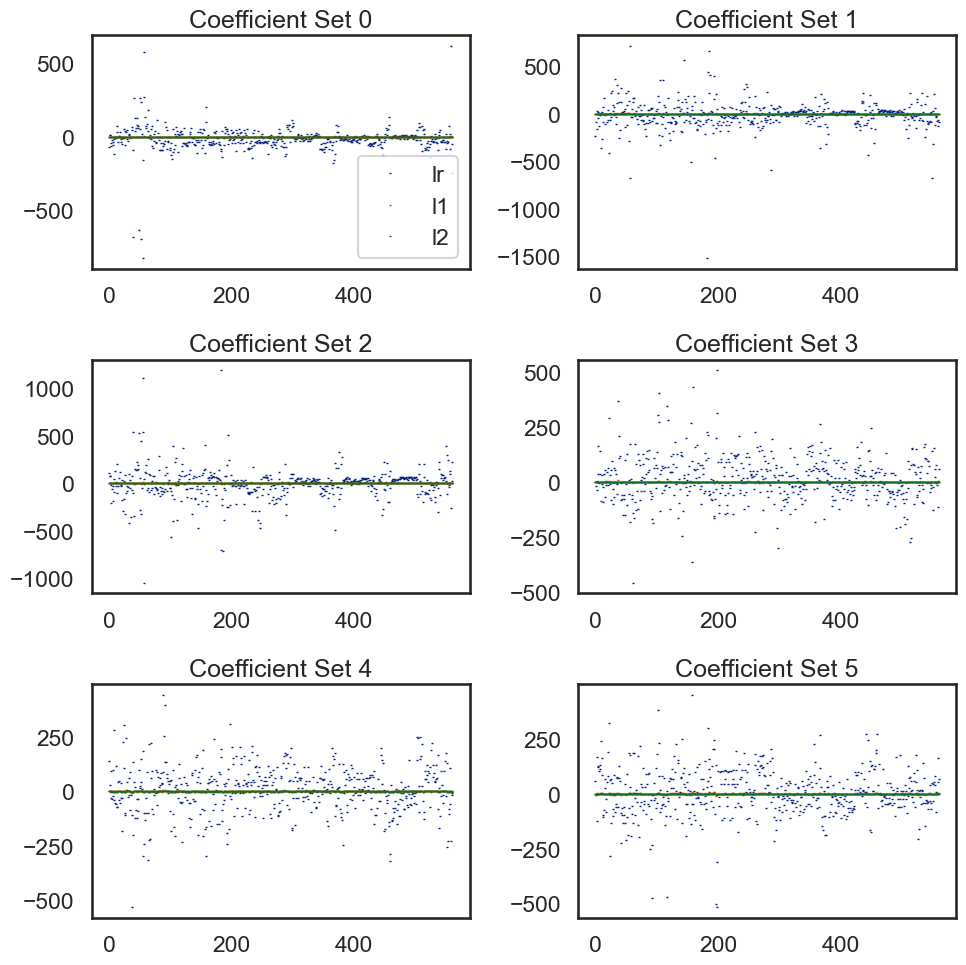

In [23]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]

    data_aux = coefficients.xs(loc, level=1, axis=1)
    data_aux.plot(marker='_', ls='', ms=1.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()




Coeficientes no modelo sem penalidade apresentam altíssima variância.

## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [24]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()



,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [25]:
y_prob.head()

,lr,l1,l2
0,1.0,0.998956,0.999998
1,1.0,0.999701,0.999654
2,1.0,0.995362,0.998875
3,1.0,0.999173,0.997831
4,1.0,0.999918,0.999306


## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [26]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [27]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.983145,0.983835,0.983485
recall,0.983172,0.983819,0.983495
fscore,0.983149,0.983815,0.983488
accuracy,0.983172,0.983819,0.983495
auc,0.989793,0.990144,0.989983


Os valores das métricas foram bem próximos para todos os métodos

## Question 8

Display or plot the confusion matrix for each model.

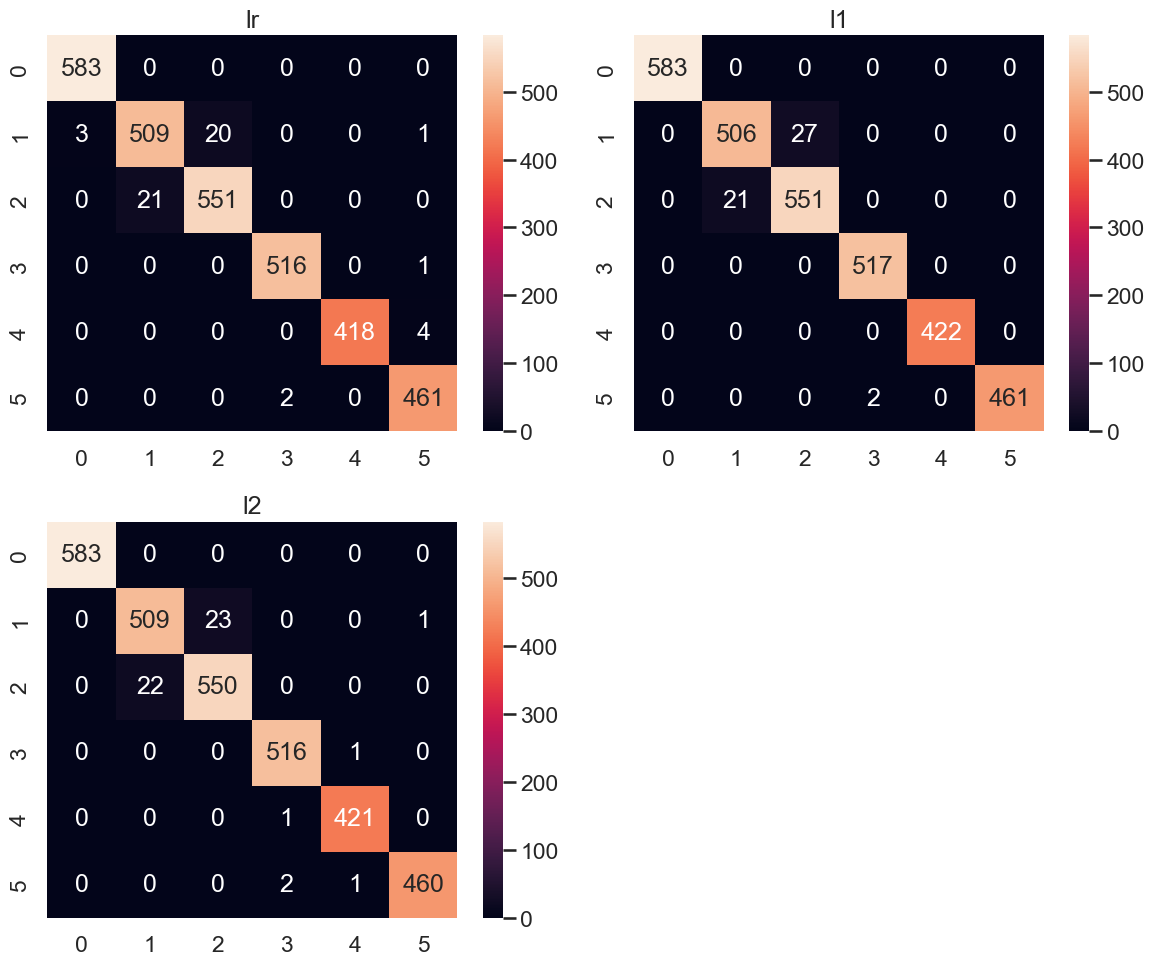

In [28]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


Matriz de confusão apresentando real x predição para os 3 métodos

## Question 9
 Identify highly correlated columns and drop those columns before building models

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold


X_data = data.iloc[:, :-1]


#threshold with .7
sel = VarianceThreshold(threshold=(.7 * (1 - .7)))
X_data = pd.DataFrame(sel.fit_transform(X_data))


feature_cols = X_data.columns[:]


# Dividindo os subjconjuntos de treino e teste, seguindo os mesmos
# Indices obtidos com Stratified Shuffle Split, agora com os dados
# Com menos features
 

X_train_new = X_data.loc[train_idx, :]

y_train_new = data.loc[train_idx, 'Activity']
 
X_test_new  = X_data.loc[test_idx, :]
y_test_new  = data.loc[test_idx, 'Activity']
 
print(X_train.shape)
print(X_train_new.shape)
 
print(X_test.shape)

(7209, 561)
(7209, 50)
(3090, 561)


O VarianceThreshold está eliminando coeficientes cujo valor em módulo está acima de um determinado limiar.

 Repeat Model building with new training data after removing higly correlated columns

In [30]:
# Try standard, L1 and L2 Logistic regression
lr_new = LogisticRegression(max_iter=500, penalty='none').fit(X_train_new, y_train_new)
lr_l1_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train_new, y_train_new)
lr_l2_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train_new, y_train_new)

C:\Users\anamb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\anamb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\anamb\AppData\Local\Packages\PythonSoftwareFoundati

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately.

In [31]:
# Combine all the coefficients into a dataframe for comparison
coefficients_new = list()
for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]],
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients_new.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients_new = pd.concat(coefficients_new, axis=1)

coefficients_new.sample(10)

lr                                                              \
              0           1           2           3           4           5   
150  -23.020664   60.837976  -98.807088   10.207708   -0.659488   51.441555   
475    5.405411   19.118259   60.279171 -101.736309  -33.705832   50.639300   
460   -2.568694   45.614470    8.398622  -14.342745   28.907145  -66.008799   
96   -29.960831  -11.795971   16.554365   61.900047   -8.570042  -28.127569   
258   -2.980766   11.742619   51.322965  -29.847119  -11.849016  -18.388683   
53   239.272200  234.371191 -324.321524   -1.993714   42.934025 -190.262178   
155   44.218751  -25.898628  144.198692    4.593678  -84.619104  -82.493388   
188  -58.215418   24.353657  -49.124180   13.089461   33.312987   36.583492   
39   -87.221266  118.940174 -106.194960  208.473629 -203.366919   69.369342   
66    -6.764503    1.231487  -89.434844 -127.388945  221.553173    0.803631   

           l1                                                          l2  \
            0         1         2         3         4         5         0   
150  0.000000  0.000000  0.000000  0.213763  0.000000 -0.824691  0.035317   
475 -0.016260  0.003300  0.466037  0.000000  0.040445  0.578898 -0.009250   
460 -0.036328  1.226917  0.000000  0.000000  0.229812 -0.111909 -0.021712   
96  -0.017306  0.000000  0.000000  0.000000  0.000000 -0.454685 -0.021696   
258  0.000000  0.000000  0.000000  0.000000 -0.006698  0.123969 -0.014777   
53  -0.237417  2.557114 -8.636039  1.023799  0.581430 -2.581737  1.054758   
155  0.000000 -1.663163  1.019234  0.441809 -0.142774 -3.240753 -0.066670   
188 -0.270069  0.000000  0.000000  0.000000  0.000000 -1.605763 -0.104374   
39  -0.370703  0.143086 -0.364190  0.000000 -3.633473 -0.095590 -0.440246   
66   0.000000  0.000000  0.000000 -0.562617  0.622778 -0.372978  0.002727   

                                                       
            1         2         3         4         5  
150  0.396440 -0.404225  0.152650 -0.172853 -0.007328  
475 -0.024028  0.026405 -0.287934  0.067134  0.227674  
460  0.149917 -0.208427  0.017147  0.201034 -0.137959  
96  -0.043987 -0.016364  0.147446 -0.001065 -0.064335  
258 -0.029332  0.023331  0.002254  0.004793  0.013731  
53   1.458431 -2.515451  0.165615  0.370761 -0.534114  
155 -0.310999  0.592557  0.084467 -0.139614 -0.159742  
188  0.027375 -0.010728  0.096019  0.041984 -0.050276  
39   0.384077  0.020298  0.331866 -0.560715  0.264720  
66  -0.085753 -0.163879 -0.348039  0.560466  0.034478

Prepare six separate plots for each of the multi-class coefficients.

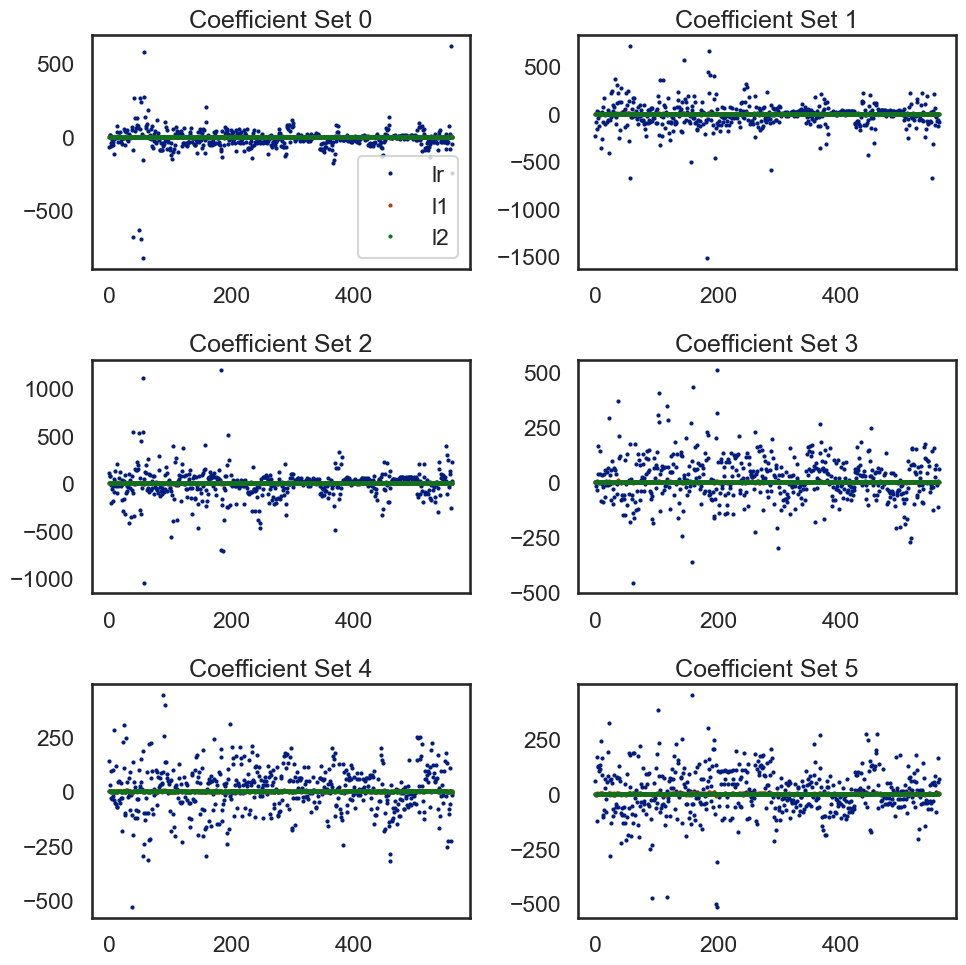

In [32]:
# try the plots
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]

    data_aux = coefficients_new.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)

    if ax is axList[0]:
        ax.legend(loc=4)

    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()


Os coeficientes apresentam uma variância dez vezes menor.

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model.

In [33]:
# Predict the class and the probability for each
y_pred_new = list()
y_prob_new = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr_new, lr_l1_new, lr_l2_new]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred_new.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob_new.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))

y_pred_new = pd.concat(y_pred_new, axis=1)
y_prob_new = pd.concat(y_prob_new, axis=1)

## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [34]:
metrics_new = list()
cm_new = dict()

for lab in coeff_labels:
    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test_new, y_pred_new[lab], average='weighted')

    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test_new, y_pred_new[lab])

    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test_new, classes=[0, 1, 2, 3, 4, 5]),
                        label_binarize(y_pred_new[lab], classes=[0, 1, 2, 3, 4, 5]),
                        average='weighted')

    # Last, the confusion matrix
    cm_new[lab] = confusion_matrix(y_test_new, y_pred_new[lab])

    metrics_new.append(pd.Series({'precision': precision, 'recall': recall,
                              'fscore': fscore, 'accuracy': accuracy,
                              'auc': auc},
                             name=lab))

metrics_new = pd.concat(metrics_new, axis=1)

#Run the metrics
metrics_new

,lr,l1,l2
precision,0.934638,0.938249,0.937088
recall,0.934628,0.938188,0.936893
fscore,0.934598,0.938165,0.936900
accuracy,0.934628,0.938188,0.936893
auc,0.960764,0.962851,0.962177


## Question 13

Display or plot the confusion matrix for each model.

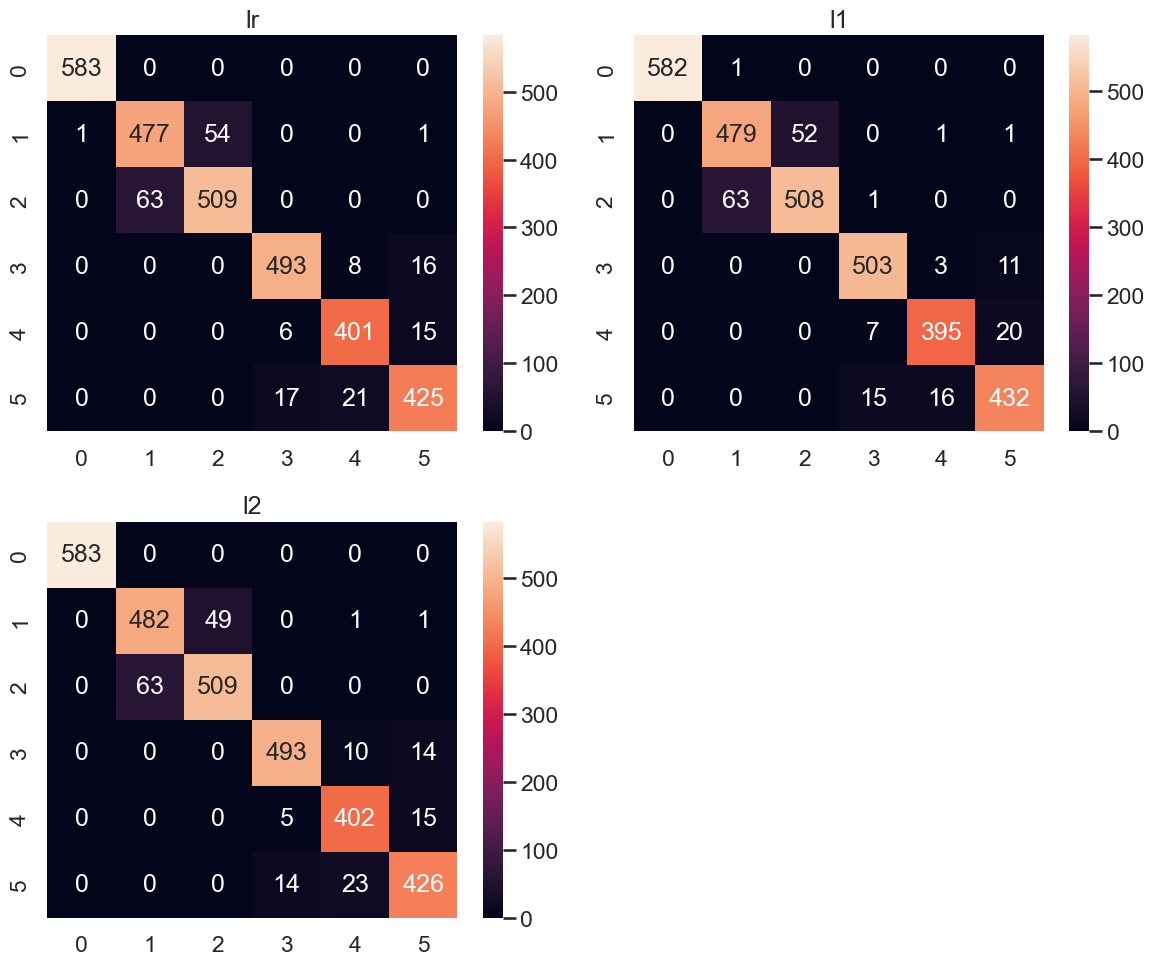

In [35]:
#plot the confusion matrix
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm_new[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);

plt.tight_layout()

In [36]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation
metrics_new-metrics

,lr,l1,l2
precision,-0.048507,-0.045586,-0.046397
recall,-0.048544,-0.045631,-0.046602
fscore,-0.048551,-0.045650,-0.046588
accuracy,-0.048544,-0.045631,-0.046602
auc,-0.029029,-0.027292,-0.027806


O sistema tem perda nas previsões, visto acima. Uma troca pelo tempo de execução ser menor. 

In [37]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation

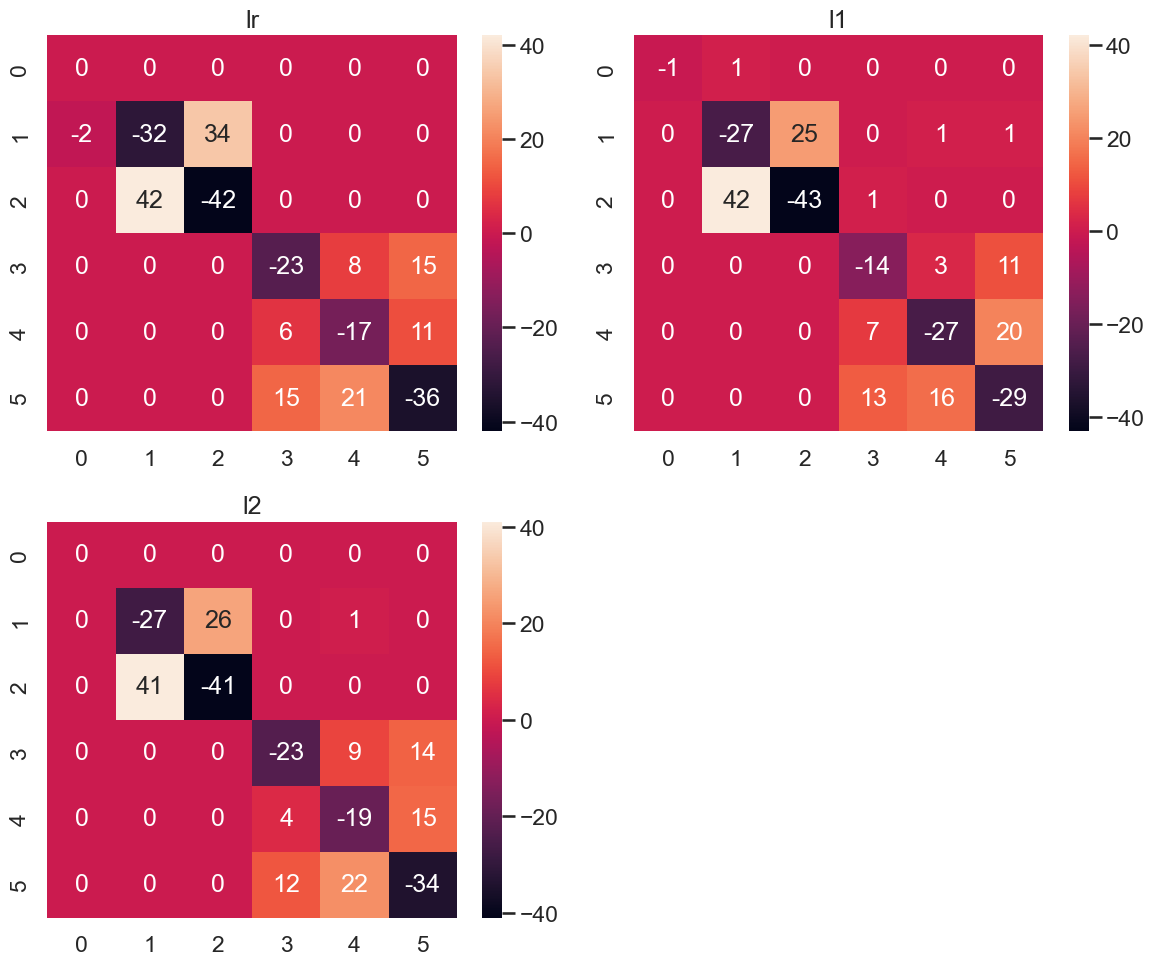

In [38]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm_new[lab]-cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);

plt.tight_layout()

# Previsão x Verdadeiro: (Modelo com redução de features) - (Modelo sem redução de features)

A matriz de confusão indica que temos menos acertos no modelo com redução de características, observados com os valores negativos na diagonal principal. Além disso, ao utilizar 561 características foi possível alcançar 98% de acurácia, enquanto ao utilizar 50 características foi alcançado cerca de 94%. Dessa forma, deve levar em conta a aplicação do problema para determinar se é necessário investir tempo para coletar, treinar e testar um conjunto com 561 dados, ou se com 10% do banco de dados já é o o suficiente, visto que a acuracia do modelo ainda é alta. 
 